#CMPE 258 HW3 - Part C1
Pure tensorflow to build neural network of 3d input, 2d output

Abhishek Bais

In [1]:
# Import packages
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error

# Generate 3d input, 2d output

In [2]:
# Generate 3-d input, 2d output
n = 100
d = 3
x = tf.random.uniform((n, d), -1, 1)

# y = 5x^2 + wx + b
weights_true = tf.constant([[3., 2., -1.], [2., 3., 1.]])
bias_true = tf.constant([[0.5], [0.5]])
print(x.shape, weights_true.shape, bias_true.shape)

y_true = tf.matmul((5 * x ** 2), weights_true, transpose_b=True) + tf.matmul(x, weights_true, transpose_b=True) + tf.transpose(bias_true)
print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y_true.shape}')

print('x is: ' + str(x[:2]))
print('y is: ' + str(y_true[:2]))

(100, 3) (2, 3) (2, 1)
x: (100, 3), weights: (2, 3), bias: (2, 1), y: (100, 2)
x is: tf.Tensor(
[[ 5.6727266e-01  5.8364868e-04 -7.2838831e-01]
 [-6.3168168e-01 -9.6258354e-01  3.2163334e-01]], shape=(2, 3), dtype=float32)
y is: tf.Tensor(
[[ 5.105603  6.778643]
 [11.091911 15.076483]], shape=(2, 2), dtype=float32)


# Generate a 3d TSNE plot of the data

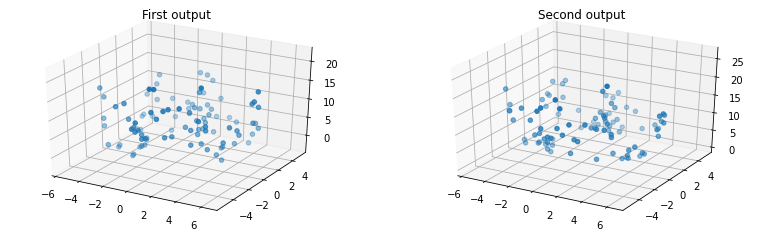

In [3]:
# Generate 3D TSNE plots for both outputs
def plot_3d(X, y, y_pred=None):
  X_tnse = TSNE(n_components=2, random_state=123).fit_transform(X)
  fig = plt.figure(figsize=plt.figaspect(0.3))
  
  # plot the first output y[:,0]
  ax = fig.add_subplot(1, 2, 1, projection='3d')
  ax.scatter(X_tnse[:,0], X_tnse[:,1], y[:,0], label='y_true')
  ax.set_title("First output")
  if y_pred is not None:
    ax.scatter(X_tnse[:,0], X_tnse[:,1], y_pred[:,0], label='y_pred', marker='v')
  
  # plot the second output y[:,1]
  ax = fig.add_subplot(1, 2, 2, projection='3d')
  ax.scatter(X_tnse[:,0], X_tnse[:,1], y[:,1], label='y_true')
  ax.set_title("Second output")
  if y_pred is not None:
    ax.scatter(X_tnse[:,0], X_tnse[:,1], y_pred[:,1], label='y_pred', marker='v')
  
plot_3d(x, y_true)

# Define a loss function
MSE

In [4]:
# Loss Function with gradient descent
class MSE:
  def __init__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true

  def loss(self):
    n = self.y_true.shape[0]
    return mean_squared_error(self.y_true, self.y_pred)

  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2 * (self.y_pred - self.y_true) / n
    return self.gradient

# Define activation functions
Relu

In [5]:
# RELU non-linear layer class
class Relu:
  def __init__(self):
    self.input_ = tf.constant([])

  def forward(self, input_):
    self.input_  = input_
    self.output = tf.clip_by_value(self.input_, clip_value_min=0, clip_value_max=tf.float32.max) 
    return self.output
    
  def backward(self, out_gradient):
    return tf.where((self.input_ > 0), out_gradient, 0)
    
  def update(self, lr):
    return


# Define backpropagation for Linear, Relu layers

In [6]:
# Layer class with backpropagation 
# Default activation is linear, pass in activation='relu' for non-linear
class Layer:
  # Init
  def __init__(self, ni=1, no=1, activation='Linear'):
    self.ni = ni
    self.no = no
    self.activation = 'Linear'

    # Init
    r1 = -1
    r2 = 1
    self.weights = tf.random.uniform((ni, no), r1, r2)
    self.bias = tf.random.uniform((1, 1), r1, r2)
    self.x = tf.zeros([ni])
    
    # activation
    if activation == 'Relu':
      self.activation = Relu()
  
  # Forward propagate input, output
  def forward(self, x):
    self.x = x
    self.output = tf.matmul(x, self.weights) + tf.transpose(self.bias)
    
    # Pass output to activation function
    if self.activation != 'Linear':
      return self.activation.forward(self.output)
    else:
      return self.output 

  # Backpropagate gradients
  def backward(self, upstream_gradient):
    gradient = upstream_gradient
    if self.activation != 'Linear':
      gradient = self.activation.backward(gradient)
    
    self.weights_gradient = tf.matmul(self.x, gradient, transpose_a=True)
    self.bias_gradient = tf.reduce_sum(gradient)
    self.x_gradient = tf.matmul(gradient, self.weights, transpose_b=True)
    return self.x_gradient

  # Update weights, bias
  def update(self, lr):
    self.weights = self.weights - lr * self.weights_gradient
    self.bias = self.bias - lr * self.bias_gradient
 
  # Print the layer params
  def dump(self):
    print('Layer has ni', self.ni)
    print('Layer has no', self.no)
    print('Layer has activation function', self.activation)
    print('Layer has weights', self.weights)
    print('Layer has bias', self.bias)

# Build the nueral net

In [7]:
# High level NN class
class Model:
  # Dump NN
  def dump(self):
    print('Builiding NN:')
    for j, layer in enumerate(self.layers):
      print('---- Layer {} ----'.format(j))
      layer.dump()

  # Init
  def __init__(self, ni=3, nh=[2], no=2, activation='Linear'):
    self.ni = ni
    self.nh = nh
    self.no = no
     
    # Build a chain of layers to form the NN
    self.layers = []
    self.layers.append(Layer(ni, no, activation='Linear'))
    self.layers.append(Layer(no, 5, activation))
    self.layers.append(Layer(5, 2, activation))
        
    # Dump the model created
    self.dump()

  # Forward propagate
  def forward(self, inputs):
    o = inputs
    for l in self.layers:
      o = l.forward(o)
    return o

  # Back propagate loss, gradients
  def backward(self, y_pred, y_true):
    mse = MSE(y_pred, y_true)
    print('Loss: ', mse.loss())
    loss_gradient = mse.backward()
    for layer in reversed(self.layers):
      loss_gradient = layer.backward(loss_gradient)

  # Update lr
  def update(self, lr):
    for layer in self.layers:
      layer.update(lr)
  
  # Train model
  def fit(self, x, y_true, lr, epochs):
    print('Propagating input: ' + str(x[:2]))
    for epoch in range(epochs):
      y_pred = self.forward(x)
      self.backward(y_pred, y_true)
      self.update(lr)

# Train neural net with non-linear relu layer

In [8]:
# Configure hyperparams of model
num_epochs = 40
lr = 0.01
ni = x.shape[1]
no = y_true.shape[1]
nh = [5,3]

In [13]:
nn = Model(ni, nh, no=no, activation='Relu')
nn.fit(x, y_true, lr, num_epochs)
y_pred = nn.forward(x)

mse = MSE(y_true, y_pred)
print('Final Loss is ', mse.loss())

Builiding NN:
---- Layer 0 ----
Layer has ni 3
Layer has no 2
Layer has activation function Linear
Layer has weights tf.Tensor(
[[-0.5045543   0.44583416]
 [ 0.36202312 -0.2211008 ]
 [ 0.02403402  0.83179736]], shape=(3, 2), dtype=float32)
Layer has bias tf.Tensor([[0.5075693]], shape=(1, 1), dtype=float32)
---- Layer 1 ----
Layer has ni 2
Layer has no 5
Layer has activation function <__main__.Relu object at 0x7f614046f610>
Layer has weights tf.Tensor(
[[-0.39819694  0.65132546 -0.21536541  0.9948869  -0.86466813]
 [ 0.28283596 -0.3615203  -0.7799609   0.16156316  0.67488265]], shape=(2, 5), dtype=float32)
Layer has bias tf.Tensor([[-0.47606015]], shape=(1, 1), dtype=float32)
---- Layer 2 ----
Layer has ni 5
Layer has no 2
Layer has activation function <__main__.Relu object at 0x7f614046f190>
Layer has weights tf.Tensor(
[[-0.42295313 -0.9176848 ]
 [-0.27579522 -0.11933923]
 [-0.92994404 -0.85779715]
 [ 0.5895026  -0.03182364]
 [ 0.88616943  0.03420329]], shape=(5, 2), dtype=float32)
L

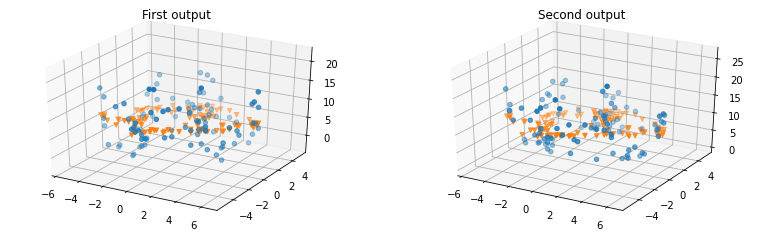

In [14]:
plot_3d(x, y_true, y_pred)

# Train neural net with only linear layers

In [11]:
nn = Model(ni, nh, no, activation='Linear')
nn.fit(x, y_true, lr, num_epochs)
y_pred = nn.forward(x)

mse = MSE(y_true, y_pred)
print('Final Loss is ', mse.loss())

Builiding NN:
---- Layer 0 ----
Layer has ni 3
Layer has no 2
Layer has activation function Linear
Layer has weights tf.Tensor(
[[-0.10071445  0.5465455 ]
 [-0.8897381  -0.12434769]
 [-0.27843285  0.8442254 ]], shape=(3, 2), dtype=float32)
Layer has bias tf.Tensor([[0.13579297]], shape=(1, 1), dtype=float32)
---- Layer 1 ----
Layer has ni 2
Layer has no 5
Layer has activation function Linear
Layer has weights tf.Tensor(
[[ 0.7884786  -0.9188025   0.03913045 -0.36553502  0.4757402 ]
 [ 0.6707034  -0.3645692   0.39382434 -0.84183764  0.246387  ]], shape=(2, 5), dtype=float32)
Layer has bias tf.Tensor([[0.96648526]], shape=(1, 1), dtype=float32)
---- Layer 2 ----
Layer has ni 5
Layer has no 2
Layer has activation function Linear
Layer has weights tf.Tensor(
[[ 0.00494075 -0.32259536]
 [ 0.15352869  0.69035006]
 [-0.6743064   0.64054656]
 [ 0.7535007   0.6521435 ]
 [-0.4095044   0.7033987 ]], shape=(5, 2), dtype=float32)
Layer has bias tf.Tensor([[-0.80974555]], shape=(1, 1), dtype=float32

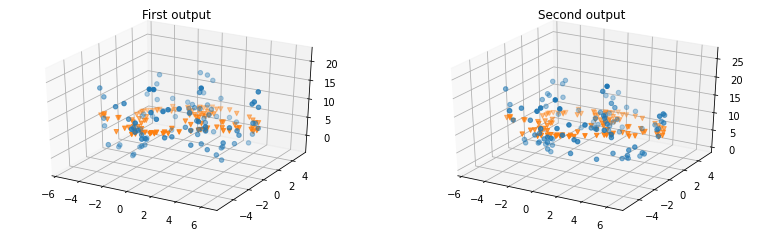

In [12]:
plot_3d(x, y_true, y_pred)